In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
#from epifit.transitions import S_I

device = "cuda" if torch.cuda.is_available() else "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter.item()))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, samples=[], start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        self._samples= samples
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
    
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            #print(dI)
            dIsample= self.get_random_from_samples()
            #random will effect the result, less than operation will lose gradient
            dI_01= dI>dIsample

            dI= dI*(1-I)
            

            I = torch.max(I, dI_01) # got infected

            states[self._states_names['I']] = I

        return states, dI
    def get_random_from_samples(self):
        return self._samples[self._t-1]

In [2]:
def sim(time_horizon, population, model, mode="run"):
  log = [population['I']]
  IMeans = [torch.tensor(0).to(device)]
  for i in range(time_horizon):
    population, dI = model(population)
    log.append(population['I'])
    IMeans.append(dI.sum()+IMeans[-1])
  log = torch.stack(log)
  IMeans = torch.stack(IMeans)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log, IMeans

tensor(10000., device='cuda:0')



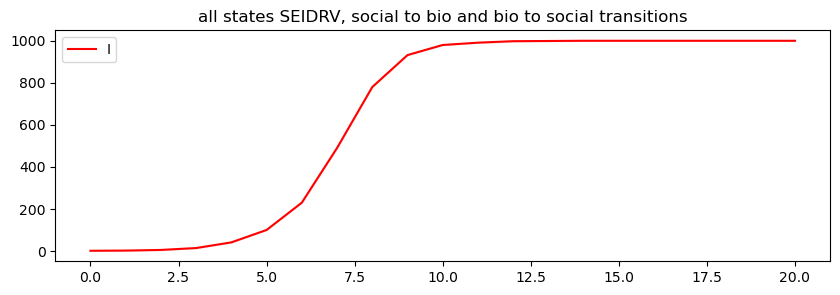

In [6]:
n = 1000 # population
avgDegree = 10  #every individual will have 10 contacts on average
pinf = 0.2  #it is the first parameter we are going to fit
time_horizon = 20

#create  dense contacts
contacts = generate_random_network(n, avgDegree)
contacts = contacts.coalesce()#make pairs unique
print(contacts.values().sum())
contacts = contacts.to_dense()
contacts = contacts.requires_grad_(True)
#random to be used
dIsamples=[]
for _ in range(time_horizon):
    dIsamples.append(torch.rand(n).to(device))
#si true 
si =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                  samples=dIsamples, device=device)
#generate real data
si_result= None
print()
with torch.no_grad():
    population = Population(n, device=device)
    si_result, _ = sim(time_horizon, population, si, mode="run")
#dIs_result= dIs_result.sum(dim=1)
stats_gt   = si_result.sum(dim=3) # si along 20 iterations
stats_gt   = stats_gt.squeeze()
stats_gt.requires_grad_(True)
colors = [("red", 'I')]
age_sizes = [n]
plot(si_result.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)


In [13]:
#si fit
si_fit = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                  samples=dIsamples, device=device)
#deinfe loss function
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(si_fit.parameters(), lr=5e-3)

0   0.05000000074505806
1   0.054999999701976776
2   0.060003526508808136
3   0.06500644981861115
4   0.07000473886728287
5   0.07497894763946533
6   0.07991385459899902
7   0.08479823172092438
8   0.08961329609155655
9   0.09434937685728073
10   0.09899817407131195
11   0.10355767607688904
12   0.10802147537469864
13   0.11240383982658386
14   0.11668562144041061
15   0.12086157500743866
16   0.1249513104557991
17   0.12892982363700867
18   0.13280603289604187
19   0.1365647315979004
20   0.14019283652305603
21   0.14370162785053253
22   0.1471100002527237
23   0.1503853052854538
24   0.15353338420391083
25   0.15654952824115753
26   0.15943872928619385
27   0.16221706569194794
28   0.16489432752132416
29   0.1674533486366272
30   0.16989551484584808
31   0.17222878336906433
32   0.1744532585144043
33   0.17653565108776093
34   0.17847923934459686
35   0.18029139935970306
36   0.1819913685321808
37   0.18357834219932556
38   0.18506291508674622
39   0.1864578276872635
40   0.187768056

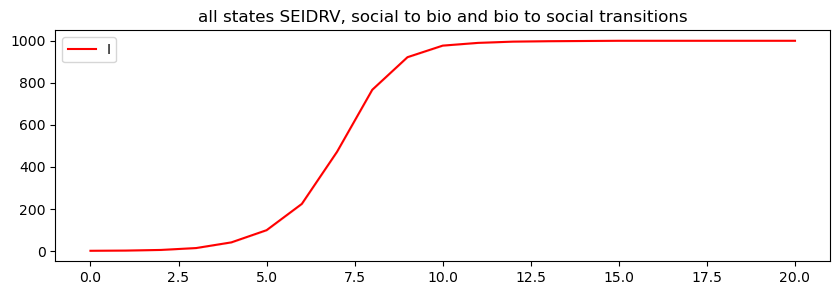

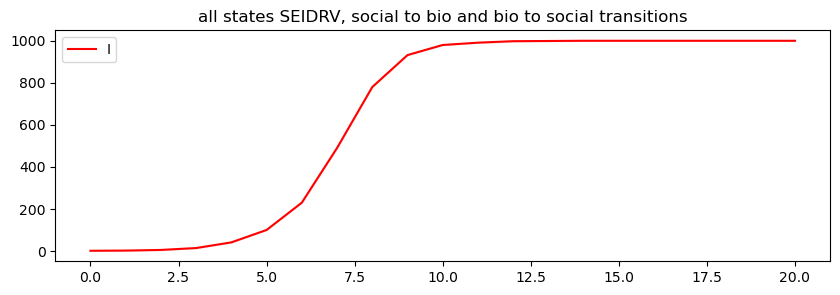

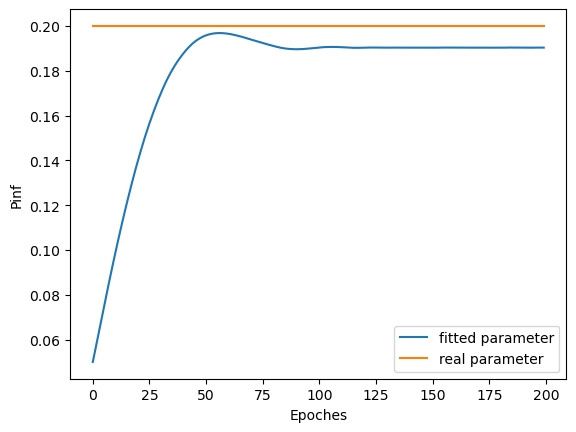

In [14]:
fitPinfs=[]
#gradient direction: negative-> positive
for i in range(200):
    print(i, " ", si_fit._pinf.item())
    optimizer.zero_grad()
    fitPinfs.append(si_fit._pinf.item())
    si_fit._t=0
    population = Population(n, device=device)
    si_pred, IMeans_pred = sim(time_horizon, population, si_fit, mode="train")
    loss = loss_fn(stats_gt, IMeans_pred)
    loss.backward(retain_graph=True)
    optimizer.step()

print_model_parameters(si_fit)
plot(si_pred.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)
plot(si_result.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)
plt.plot(fitPinfs, label='fitted parameter')
plt.plot([pinf]*len(fitPinfs), label='real parameter')
plt.xlabel("Epoches")
plt.ylabel("Pinf")
plt.legend()
